In [1]:
# imports
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import kci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.Dataset import load_dataset

from mixed import generate_mixed_causal_dataframe

from IPython.display import Image, display

from utils import basic_causal_dataframe, getCausalRelationship, visualize_quantum_solutions

import numpy as np
from dotenv import load_dotenv
import os
import pydot

from SAT.classical import solveClassicalSAT
from SAT.fixedPointQuantum import solveFixedQuantunSAT
from SAT.validateSolution import validate_all_solutions

from qiskit_ibm_runtime import QiskitRuntimeService


/home/lino/cSAT/venv-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_graph_from_causes(direct_causes):
    nodes = set()
    for rel in direct_causes:
        nodes.add(rel["node1"])
        nodes.add(rel["node2"])
    graph = pydot.Dot("my_graph", graph_type="digraph")
    for node in nodes:
        graph.add_node(pydot.Node(node))

    for rel in direct_causes:
        if rel["edge"] == "direct" and rel["exists"]:
            graph.add_edge(pydot.Edge(rel["node1"], rel["node2"]))
        # elif rel["edge"] == "latent" and rel["exists"]:
        #     graph.add_edge(pydot.Edge(rel["node1"], rel["node2"], style="dotted", arrowhead="none"))
    
    return graph

# Load the boston housing dataset

In [3]:
# data, labels = load_dataset("boston_housing")

In [4]:
data = generate_mixed_causal_dataframe()

In [5]:
data

,X,A,C,O,Y
0,3.745401,0,0,1,-6.660834
1,9.507143,1,0,3,-16.305783
2,7.319939,0,2,2,-12.698094
3,5.986585,0,0,2,-12.056148
4,1.560186,0,0,0,-2.514401
...,...,...,...,...,...
995,0.915821,0,2,0,-0.017407
996,9.173136,0,0,3,-17.588464
997,1.368186,0,0,0,-1.941082
998,9.502374,1,0,3,-16.265281


In [6]:
# take a subset of the data to speed up the process
# data = data[:150, :]

In [7]:
# Convert DataFrame to numpy array and create labels
labels = list(data.columns)
data_array = data.values
cg = pc(data_array, indep_test=kci, kernelZ="Polynomial", show_progress=True)

Depth=2, working on node 4: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]  


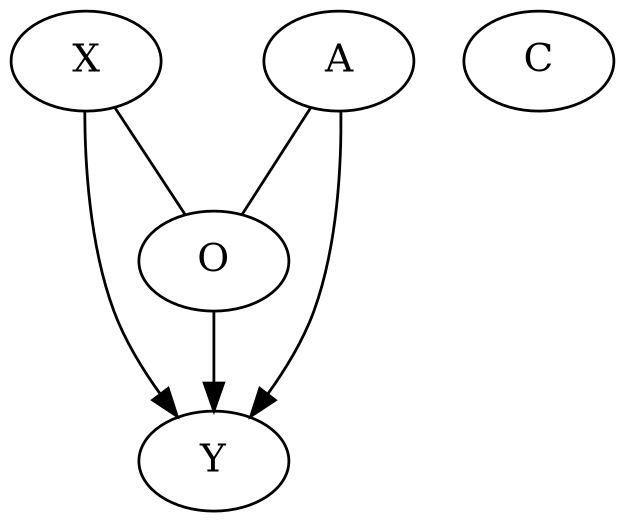

In [8]:
pyd = GraphUtils.to_pydot(cg.G, labels=labels)

# show pyd image
display(Image(pyd.create_png()))

In [9]:
# change gtarph node names 
for i, node in enumerate(cg.G.nodes):
    node.name = labels[i]

In [10]:
# save the node mapping and the reversed mapping
node_mapping = {node.name: index for index, node in enumerate(cg.G.nodes)}
reversed_node_mapping = {index: node.name for index, node in enumerate(cg.G.nodes)}

In [11]:
node_mapping

{'X': 0, 'A': 1, 'C': 2, 'O': 3, 'Y': 4}

In [12]:
cg.G.graph

array([[ 0,  0,  0, -1, -1],
       [ 0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0],
       [-1, -1,  0,  0, -1],
       [ 1,  1,  0,  1,  0]])

In [13]:
# Now we need to extract the edges:
edges = []
indices = np.where(cg.G.graph != 0)
processed_pairs = set()

for i, j in zip(indices[0], indices[1]):
    
    node_pair = frozenset([i.item(), j.item()])
    
    if node_pair in processed_pairs:
        continue
        
    if cg.G.graph[i,j] == -1 and cg.G.graph[j,i] == 1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "->"
        })
    
    elif cg.G.graph[i,j] == -1 and cg.G.graph[j,i] == -1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "--"
        })
        processed_pairs.add(node_pair) 
    
    elif cg.G.graph[i,j] == 1 and cg.G.graph[j,i] == 1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "<->"
        })
        processed_pairs.add(node_pair)

for edge in edges:
    print(f"{edge['from']} {edge['type']} {edge['to']}")

X -- O
X -> Y
A -- O
A -> Y
O -> Y


In [14]:
# create a list of possible causal relationship in the variables
causal_dict = {}
for node1 in node_mapping:
    for node2 in node_mapping:
        for edge in ['direct']:
            causal_dict[(node1, node2, edge)] = len(causal_dict) + 1
            
reversed_causal_dict = {v: k for k, v in causal_dict.items()}

# Now we need to map the edges to the SAT clauses

In [15]:
SATClauses = []

for item in edges:
    if item['type'] == '->':
        # there MUST be a direct edge from node1 to node2 and NO direct edge from node2 to node1
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')]])
        SATClauses.append([-causal_dict[(item['to'], item['from'], 'direct')]])
    elif item['type'] == '--':
        # there MUST be exactly one direct edge: either from node1 to node2 OR from node2 to node1 (XOR)
        # For XOR in CNF: (A OR B) AND (NOT A OR NOT B)
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')], causal_dict[(item['to'], item['from'], 'direct')]])
        SATClauses.append([-causal_dict[(item['from'], item['to'], 'direct')], -causal_dict[(item['to'], item['from'], 'direct')]])
    elif item['type'] == '<->':
        # there MUST be a direct edge from node1 to node2 and a direct edge from node2 to node1
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')]])
        SATClauses.append([causal_dict[(item['to'], item['from'], 'direct')]])

In [16]:
len(SATClauses)

10

In [17]:
variable_set = set()
for clause in SATClauses:
    for var in clause:
        variable_set.add(abs(var))
        
new_var = list(range(1, len(variable_set) + 1))

# create a mapping from old variable to new variable
cnf_variable_mapping = {}
for i, var in enumerate(variable_set):
    cnf_variable_mapping[var] = new_var[i]
    
# reverse the mapping
reverse_cnf_variable_mapping = {v: k for k, v in cnf_variable_mapping.items()}

# print(f"LOG: The variable mapping is: {cnf_variable_mapping}\n")
# print(f"LOG: The reverse variable mapping is: {reverse_cnf_variable_mapping}\n")

# so the new cnf will be
new_cnf = []
for clause in SATClauses:
    new_clause = []
    for var in clause:
        new_var = cnf_variable_mapping[abs(var)]
        new_clause.append(new_var if var > 0 else -new_var)
    new_cnf.append(new_clause)
    
print(f"LOG: The new CNF is: {new_cnf}\n")

LOG: The new CNF is: [[1, 5], [-1, -5], [2], [-8], [3, 6], [-3, -6], [4], [-9], [7], [-10]]



In [18]:
# solve the classical SAT
is_sat, model = solveClassicalSAT(new_cnf)

In [19]:
# just to map back the model
temp = []
for item in model:
    temp.append(reverse_cnf_variable_mapping[abs(item)] if item > 0 else -reverse_cnf_variable_mapping[abs(item)])
classical_model = temp

# output the results:
print(f"LOG: Classical SAT solver returned: {is_sat}\n")
print(f"LOG: The model is: {classical_model}\n")

LOG: Classical SAT solver returned: True

LOG: The model is: [4, 5, 9, 10, -16, -17, 20, -21, -22, -24]



In [20]:
is_sat, quantum_solutions = solveFixedQuantunSAT(new_cnf, 8, np.sqrt(0.1))

LOG: Circuit with 20 qubits
LOG: Circuit created, circuit depth: 505
LOG: Silhouette score: 0.9954752373512381


Since there are too many qubits to simulate we're gonna need to use a real quantum hardware. Take into account that right now, Leonardo and other high-performance computers are able to simulate a maximum of 51 qubits.

In [21]:
load_dotenv()
API_KEY = os.getenv("IBM_API_KEY")

QiskitRuntimeService.save_account(instance="crn:v1:bluemix:public:quantum-computing:us-east:a/efee6188d31b49b79c1eb68b9ca41f1a:57401bfd-f1c2-4d2f-a515-60bb6f5c784e::", token=API_KEY, overwrite=True, set_as_default=True)

In [22]:
is_sat, quantum_solutions = solveFixedQuantunSAT(new_cnf, 8, np.sqrt(0.1), simulation=False)

LOG: Circuit with 20 qubits
LOG: Circuit created, circuit depth: 505
LOG: Running on IBM Quantum Hardware...
Sampler job ID: d1n2kf95jdrc73dq45sg
LOG: Silhouette score: 0.9997020694712879


In [23]:
logging = True

In [24]:
# check for quantum solutions validity
if is_sat:
    
    # Validate all solutions, which is an array of boolean values
    validity = validate_all_solutions(new_cnf, quantum_solutions)
    
    # count the number of valid solutions
    valid_count = sum(validity)
    print(f"\033[1m\033[4mLOG: The number of valid quantum solutions is: {valid_count} out of {len(quantum_solutions)}\033[0m\n")
    
    # Filter out only the valid solutions
    quantum_solutions = [solution for solution, valid in zip(quantum_solutions, validity) if valid]

# Map back all solutions using reverse_cnf_variable_mapping
mapped_solutions = []
for solution in quantum_solutions:
    mapped_solution = []
    for item in solution:
        mapped_var = reverse_cnf_variable_mapping[abs(item)]
        mapped_solution.append(mapped_var if item > 0 else -mapped_var)
    mapped_solutions.append(mapped_solution)

if logging: print(f"LOG: Quantum SAT solver returned: {is_sat}\n")
if logging: print(f"LOG: The models are: {mapped_solutions}\n")

# check if quantum does indeed contain the classical solution
if classical_model in mapped_solutions:
    print(f"\033[1m\033[4mLOG: The classical solution is in the quantum solutions!\033[0m\n")
else:
    if logging: print(f"LOG: The classical solution is NOT in the quantum solutions\n")
    
# get classical direct cause
classical_direct_causes = [rel for rel in getCausalRelationship(classical_model, reversed_causal_dict) if rel["edge"] == "direct" and rel["exists"]]

# Generate and save classical solution
if classical_direct_causes:
    classical_graph = generate_graph_from_causes(classical_direct_causes)
    classical_graph.write_png("output/PC/classical_output.png")

# Generate visualization of quantum solutions
if mapped_solutions:
    visualize_quantum_solutions(mapped_solutions, "output/PC", reversed_causal_dict, logging=logging)

# After defining generate_graph_from_causes function, add this to visualize the PC output directly
def visualize_pc_output():
    # Create a graph to visualize the PC algorithm output
    pc_graph = pydot.Dot("pc_graph", graph_type="digraph")
    
    # Add nodes
    for node_name in node_mapping:
        pc_graph.add_node(pydot.Node(node_name))
    
    # Add edges based on the extracted edges
    for edge in edges:
        if edge['type'] == '->':
            pc_graph.add_edge(pydot.Edge(edge['from'], edge['to']))
        elif edge['type'] == '--':
            pc_graph.add_edge(pydot.Edge(edge['from'], edge['to'], dir="none"))
        elif edge['type'] == '<->':
            pc_graph.add_edge(pydot.Edge(edge['from'], edge['to'], dir="both"))
    
    # Save the graph
    pc_graph.write_png("output/PC/PC_output.png")
    if logging: print("LOG: Saved PC algorithm output visualization\n")

# Generate the PC algorithm output visualization
visualize_pc_output()

LOG: The number of valid quantum solutions is: 41 out of 9942

LOG: Quantum SAT solver returned: True

LOG: The models are: [[-4, 5, 9, 10, 16, -17, 20, -21, -22, -24], [4, 5, 9, 10, -16, -17, 20, -21, -22, -24], [4, 5, -9, 10, -16, 17, 20, -21, -22, -24], [-4, 5, 9, 10, 16, -17, 20, -21, -22, -24], [4, 5, 9, 10, -16, -17, 20, -21, -22, -24], [-4, 5, -9, 10, 16, 17, 20, -21, -22, -24], [4, 5, -9, 10, -16, 17, 20, -21, -22, -24], [4, 5, 9, 10, -16, -17, 20, -21, -22, -24], [4, 5, 9, 10, -16, -17, 20, -21, -22, -24], [-4, 5, 9, 10, 16, -17, 20, -21, -22, -24], [4, 5, -9, 10, -16, 17, 20, -21, -22, -24], [-4, 5, -9, 10, 16, 17, 20, -21, -22, -24], [4, 5, 9, 10, -16, -17, 20, -21, -22, -24], [-4, 5, 9, 10, 16, -17, 20, -21, -22, -24], [4, 5, 9, 10, -16, -17, 20, -21, -22, -24], [-4, 5, -9, 10, 16, 17, 20, -21, -22, -24], [-4, 5, -9, 10, 16, 17, 20, -21, -22, -24], [-4, 5, -9, 10, 16, 17, 20, -21, -22, -24], [-4, 5, -9, 10, 16, 17, 20, -21, -22, -24], [-4, 5, 9, 10, 16, -17, 20, -21, -22, -